# Explore GLATHIDA

In [69]:
import pandas as pd
import geopandas as gpd
import os, glob
import salem
import numpy as np
import shapely.geometry as shpg
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import glob
%matplotlib inline

## Files

In [70]:
gtd_dir = '..\\GlaThiDa_2014'
rgi_dir = '..\\rgi50\\'
f_T = os.path.join(gtd_dir, 'T.csv')

## Distance function

In [71]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between one point 
    on the earth and an array of points (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r

## Select IDS that are candidates

In [72]:
pda = pd.read_csv(f_T, header=0, encoding='iso8859_15', sep=';', low_memory=False)

In [ ]:
pda['GlaThiDa_ID'] = pda.GlaThiDa_ID.values.astype(np.int)
pda.columns

In [ ]:
print(len(pda))
pda = pda.dropna(subset=['AREA', 'LON', 'LAT', 'MEAN_THICKNESS'])
print(len(pda))
print pda[pda.LAT <=0]

## See if these data follow a volume area scaling

In [75]:
pda['VOLUME'] = pda['AREA'] * pda['MEAN_THICKNESS'] * 1e-3

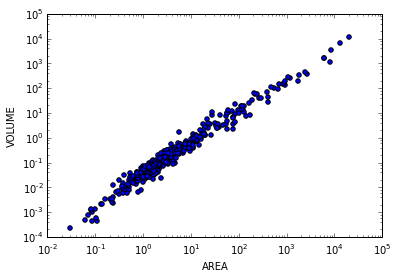

In [76]:
pda.plot(x='AREA', y='VOLUME', kind='scatter', logx=True, logy=True)
plt.show();

## See where they are 

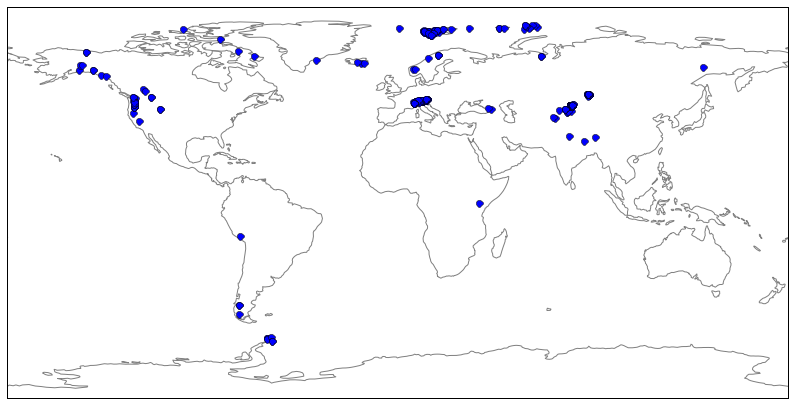

In [78]:
f = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
# mark a known place to help us geo-locate ourselves
for lon, lat in zip(pda.LON.values, pda.LAT.values):
    ax.plot(lon, lat, 'bo', markersize=7, transform=ccrs.Geodetic())
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='gray');
ax.set_extent([-180, 180, -90, 90])

## Fore all IDs, decide in which RGI region they could be

First read RGI regions

In [79]:
shp = rgi_dir + '00_rgi50_regions/00_rgi50_O1Regions.shp'
rgi_r = salem.utils.read_shapefile(shp)

In [80]:
rgi_r[['Primary_ID','Secondary_']]

,Primary_ID,Secondary_
0,Alaska,01
1,Alaska,01
2,Western Canada and US,02
3,Arctic Canada North,03
4,Arctic Canada South,04
5,Greenland,05
6,Iceland,06
7,Svalbard,07
8,Scandinavia,08
9,Russian Arctic,09


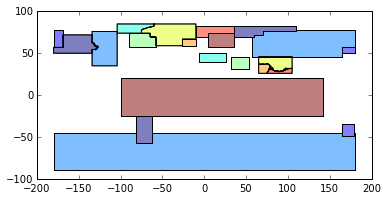

In [81]:
rgi_r.plot();

In [82]:
region_candidates = []
for k, row in pda.iterrows():
    gp = shpg.Point(row.LON, row.LAT)
    rgi_reg = []
    for i, r in rgi_r.iterrows():
        if r.geometry.contains(gp):
            rgi_reg.append(r['Secondary_'])
    assert len(rgi_reg) == 1
    region_candidates.append(rgi_reg[0])

In [83]:
pda['RGI_REG'] = region_candidates

In [84]:
region_candidates = set(region_candidates)
len(region_candidates)

17

## Loop over regions and find the glaciers

In [ ]:
found = []
gdt_ids = []
for region in region_candidates:
    print region
    rgi_shp = list(glob.glob(os.path.join(rgi_dir, "*", region + '_rgi50_*.shp')))[0]
    pdrgi = salem.utils.read_shapefile(rgi_shp, cached=True)
    # glacier for which we want to find
    pda_sub = pda.loc[pda.RGI_REG == region]
    # go
    for i, row in pda_sub.iterrows():
        lon, lat = row.LON, row.LAT
        pdrgi['DIST'] = haversine(lon, lat, pdrgi.CenLon.values, pdrgi.CenLat.values)
        sortrgi = pdrgi.sort_values(by='DIST')
        how_long = 0
        gp = shpg.Point(lon, lat)
        gdt_ids.append(row.GlaThiDa_ID)
        while True:
            s = sortrgi.iloc[how_long]
            if how_long > 10:
                found.append(None)
                break
            if s.geometry.buffer(0).contains(gp):
                found.append(sortrgi.iloc[how_long].RGIId)
                break
            how_long += 1

In [86]:
pda_id = pda.set_index('GlaThiDa_ID')
found_s = pd.Series(found, index=gdt_ids)
pda_id['RGI_ID'] = found_s

#### How many did we find?

In [88]:
print(len(pda_id))
print(len(pda_id.dropna(subset=['RGI_ID'])))

398
277


## Correct with and merge works by Johannes 

In [89]:
f_alps = '..\\Manual_links_GlaThiDa_to_RGI_ALPS_20160216.csv'

In [90]:
pd_alps = pd.read_csv(f_alps).set_index('GlaThiDa_ID')

In [91]:
pda_id.loc[pd_alps.index, 'RGI_ID'] = pd_alps['RGI_equivalent']
print(len(pda_id))
print(len(pda_id.dropna(subset=['RGI_ID'])))

398
281


In [92]:
f_wgms = '..\\Manual_links_WGMS_to_RGI_GlaThiDa_Leclercq_WORLD_20160212.csv'

In [93]:
pd_world = pd.read_csv(f_wgms)
pd_world = pd_world.dropna(subset=['GlaThiDa_ID'])
pd_world = pd_world.dropna(subset=['RGI_ID'])
# These are glaciers that have no thickness data
pd_world = pd_world.loc[~pd_world.GlaThiDa_ID.isin([1629.,341.,551.,196.,233.])]
pd_world = pd_world.set_index('GlaThiDa_ID')

In [ ]:
pda_id.loc[pd_world.index, 'RGI_ID'] = pd_world['RGI_ID']
print(len(pda_id))
print(len(pda_id.dropna(subset=['RGI_ID'])))

## OK we have a final candidate list

In [95]:
pda_tofilt = pda_id.dropna(subset=['RGI_ID']).copy()

Those are now the glaciers which have been linked automatically (correction from the manual links included)

In [96]:
len(pda_tofilt)

283

For the automatically found glaciers, we exclude those that have an extreme difference in area:

## Exclude the glaciers with extreme difference in area 

In [97]:
# First get the RGI area
pda_tofilt['RGI_REG'] = [r.split('-')[-1].split('.')[0] for r in pda_tofilt.RGI_ID.values]

In [98]:
area = []
gdt_ids = []
for region in set(pda_tofilt['RGI_REG']):
    rgi_shp = list(glob.glob(os.path.join(rgi_dir, "*", region + '_rgi50_*.shp')))[0]
    pdrgi = salem.utils.read_shapefile(rgi_shp, cached=True)
    # glacier for which we want to find
    pda_sub = pda_tofilt.loc[pda_tofilt.RGI_REG == region]
    pdrgi = pdrgi.set_index('RGIId')
    area.extend(pdrgi.loc[pda_sub.RGI_ID].Area.values)
    gdt_ids.extend(pda_sub.index.values)

In [99]:
pda_tofilt['RGI_Area'] = pd.Series(area, index=gdt_ids)

## There are HUGE differences...

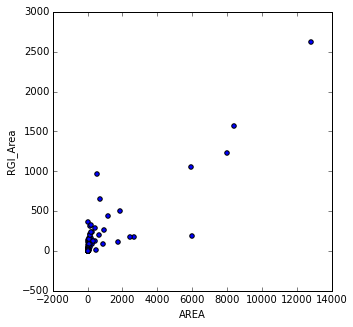

In [100]:
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
pda_tofilt.plot(x='AREA', y='RGI_Area', kind='scatter', ax=ax);

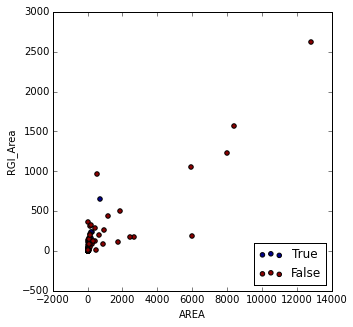

In [101]:
pda_tofilt['isclose'] =np.isclose(pda_tofilt['RGI_Area'], pda_tofilt['AREA'], rtol=0.15, atol=0.4)
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
groups = pda_tofilt.groupby('isclose').groups
pda_tofilt.loc[groups[True]].plot(x='AREA', y='RGI_Area', kind='scatter', ax=ax, color='DarkBlue', label='True');
pda_tofilt.loc[groups[False]].plot(x='AREA', y='RGI_Area', kind='scatter', ax=ax, color='DarkRed', label='False');
plt.legend(loc='lower right');

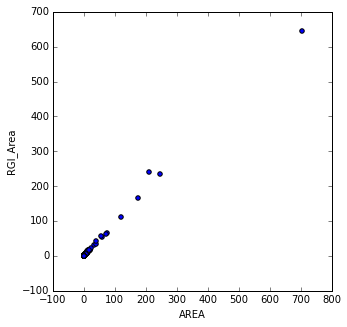

In [34]:
pda_final = pda_tofilt.loc[groups[True]]
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
pda_final.plot(x='AREA', y='RGI_Area', kind='scatter', ax=ax);

In [35]:
len(pda_final)

167

In [36]:
pda_final['RGI_AREA'] = pda_final['RGI_Area']
pda_final['GTD_AREA'] = pda_final['AREA']

### There are still some RGI duplicates...

In [41]:
badbad = [199, 419, 104, 103, 318, 315, 307, 311, 106, 314, 525, 107, 316, 96, 102, 310, 101, 505, 506, 309]
pda_nodupl = pda_final.loc[~pda_final.index.isin(badbad)].copy()
pda_nodupl['THICK_VASCALING'] = 0.0340 * pda_nodupl['GTD_AREA'] ** 1.375 / pda_nodupl['GTD_AREA'] * 1000
gn = pda_nodupl.groupby('RGI_ID')
kept = []
for n, d in gn:
    if len(d) > 1:
        print()
        print(d)
        break

In [42]:
len(pda_nodupl)

147

## Write out the data

In [44]:
pda_nodupl.columns

Index([                 u'POLITICAL_UNIT',                    u'GLACIER_NAME',
                             u'SOURCE_ID',                              u'ID',
                                   u'LAT',                             u'LON',
                                  u'YEAR',                            u'AREA',
                            u'MEAN_SLOPE',                  u'MEAN_THICKNESS',
               u'ACCURACY_MEAN_THICKNESS',               u'MAXIMUM_THICKNESS',
                u'ACCURACY_MAX_THICKNESS',                     u'SURVEY_DATE',
                         u'SURVEY_METHOD',         u'NUMBER_OF_SURVEY_POINTS',
             u'NUMBER_OF_SURVEY_PROFILES', u'TOTAL_LENGTH_OF_SURVEY_PROFILES',
                  u'INTERPOLATION_METHOD',                    u'INVESTIGATOR',
                     u'SPONSORING_AGENCY',                      u'REFERENCES',
                               u'REMARKS',                          u'VOLUME',
                               u'RGI_REG',          

In [45]:
pda_fin = pda_nodupl[['GLACIER_NAME', 'RGI_ID', 'GTD_AREA', 'RGI_AREA', 'MEAN_THICKNESS', 
                      'MAXIMUM_THICKNESS', 'LON', 'LAT']].copy()
pda_fin.columns = ['NAME', 'RGI_ID', 'GTD_AREA', 'RGI_AREA', 'MEAN_THICKNESS', 
                   'MAXIMUM_THICKNESS', 'GTD_LON', 'GTD_LAT']

In [46]:
pda_fin['NAME'] = [n.strip().title() for n in pda_fin['NAME']]

In [54]:
pda_fin.to_csv('..\\rgi_glathida_links_2014_RGIV5.csv', encoding='utf-8')

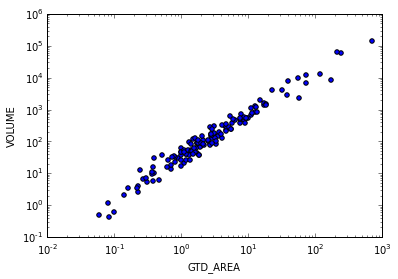

In [48]:
pda_fin['VOLUME'] = pda_fin['GTD_AREA'] * pda_fin['MEAN_THICKNESS']
pda_fin.plot(x='GTD_AREA', y='VOLUME', kind='scatter', logx=True, logy=True)
plt.show();

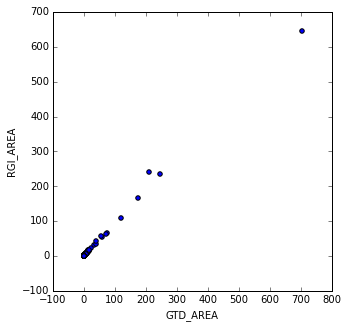

In [49]:
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
pda_fin.plot(x='GTD_AREA', y='RGI_AREA', kind='scatter', ax=ax);

In [50]:
pda_fin.loc[pda_fin.GTD_AREA > 100]

,NAME,RGI_ID,GTD_AREA,RGI_AREA,MEAN_THICKNESS,MAXIMUM_THICKNESS,GTD_LON,GTD_LAT,VOLUME
GlaThiDa_ID,,,,,,,,,
126,Borebreen,RGI50-07.00464,120,110.250,111,185,13.9000,78.4417,13320
147,Sveabreen,RGI50-07.00474,174,165.161,49,140,13.6135,78.6945,8526
202,Black Rapids,RGI50-01.00037,246,234.583,235,603,-146.5000,63.4800,57810
205,Kvitoeyjoekulen,RGI50-07.01394,705,645.801,200,NaN,32.6258,80.2139,141000
347,Hoffellsjoekull,RGI50-06.00466,212,240.050,300,560,-15.5700,64.4800,63600


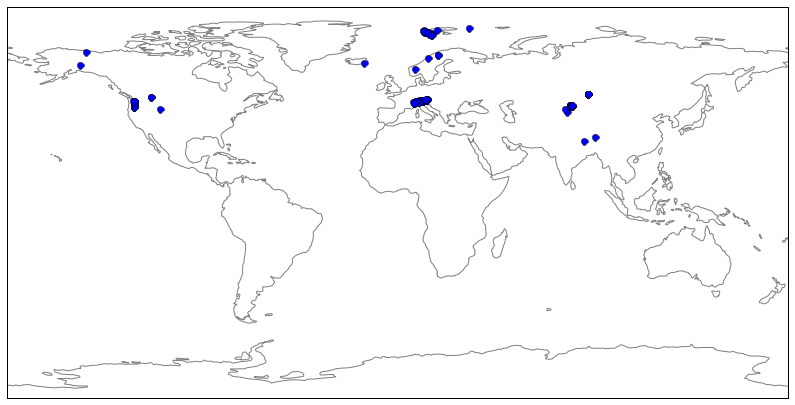

In [51]:
f = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
# mark a known place to help us geo-locate ourselves
for lon, lat in zip(pda_fin.GTD_LON.values, pda_fin.GTD_LAT.values):
    ax.plot(lon, lat, 'bo', markersize=7, transform=ccrs.Geodetic())
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='gray');
ax.set_extent([-180, 180, -90, 90])